<a href="https://colab.research.google.com/github/sli032/BIO-PHY4100/blob/main/DNA%3ARNA_polyer_modeling_HOOMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation & Render code

Run the code only once, then click the arrow to hide them.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!conda install -c conda-forge hoomd gsd

In [ ]:
!conda install -c conda-forge fresnel freud

In [4]:
import math
import warnings

import fresnel
import freud
import gsd.hoomd
import hoomd
import IPython
import matplotlib
import numpy
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=400, h=400)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04

    if (hasattr(snapshot, 'log')
            and 'particles/md/pair/LJ/energies' in snapshot.log):
        energies = snapshot.log['particles/md/pair/LJ/energies']
        mapper = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=numpy.min(energies),
                                             vmax=numpy.max(energies),
                                             clip=True),
            cmap=matplotlib.cm.get_cmap(name='viridis'))
        geometry.color[:] = fresnel.color.linear(mapper.to_rgba(energies))
        geometry.material.primitive_color_mix = 1

    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=20)._repr_png_())


warnings.filterwarnings('ignore', module='hoomd')

# Introducing molecular dynamics

This hands-on workshop introduces the basic concepts of HOOMD-blue and will teach you how to run a molecular dynamics simulation. For more details, information that may be helpful when completing the exercises, see the [HOOMD-blue documentation](https://hoomd-blue.readthedocs.io/).

**Google Colab users:** Click the "Copy to Drive" button in the toolbar to save this notebook and any edits that you make to your Google Drive.

## Create the simulation and initial state


In [5]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=2)

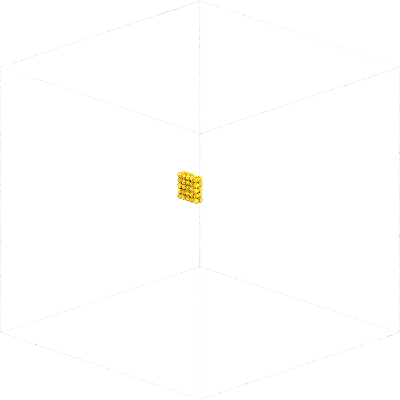

In [6]:
snapshot = hoomd.Snapshot()

a = 1
chainN = 50

particles = [[0.,0.,0.]]
step = numpy.array([-a, 0., 0.])
turnstep = numpy.array([0., a, 0.])
upstep = numpy.array([0., 0., a])
for i in range(1, chainN):
  if i % 5 == 0:
    step = -step
    if (i/5) % 5 == 0:
      particles.append(particles[-1] + upstep)
      turnstep = -turnstep
    else:
      particles.append(particles[-1] + turnstep)
  else:
    particles.append(particles[-1] + step)
bonds = [[i, i+1] for i in range(chainN - 1)]
angles = [[i, i+1, i+2] for i in range(chainN - 2)]


snapshot.particles.N = len(particles)
snapshot.particles.position[:] = particles
snapshot.particles.types = ['A']

snapshot.bonds.N = len(bonds)
snapshot.bonds.group[:] = bonds
snapshot.bonds.types = ['bond']


snapshot.angles.N = len(angles)
snapshot.angles.group[:] = angles
snapshot.angles.types = ['bend']

snapshot.configuration.box = [50, 50, 50, 0, 0, 0]
render(snapshot)

In [7]:
sim.create_state_from_snapshot(snapshot)

## Molecular dynamics classes

The MD integrator numerically integrates the equations of motion:

In [8]:
integrator = hoomd.md.Integrator(dt=0.005)

You need a neighbor list to compte pairwise interactions:

In [9]:
cell = hoomd.md.nlist.Cell(buffer=0.4)

In [10]:
harmonic = hoomd.md.bond.Harmonic()
harmonic.params['bond'] = dict(k=100.0, r0=1.2)
integrator.forces.append(harmonic)

The integration **method** sets the specific equations of motion that apply to a subset of particles:

In [11]:
brownian = hoomd.md.methods.Brownian(filter=hoomd.filter.All(), kT=1.5)
integrator.methods.append(brownian)
sim.operations += integrator

## Logging energy and dump trajectory

HOOMD-blue can log array quantities, such as the per particle energies. It can also include user-defined loggable quantities. Here we create a RadiusGyration class for logging, and include all logged quantities in a GSD trajectory:

In [12]:
class RadiusGyration(metaclass=hoomd.logging.Loggable):
    def __init__(self, sim):
      self.sim = sim
    @hoomd.logging.log
    def rg(self):
      snap = self.sim.state.get_snapshot()
      positions = snap.particles.position
      N = positions.shape[0]
      if N == 0:
          return 0.0
      r_cm = numpy.mean(positions, axis=0)
      rg2 = numpy.sum(numpy.sum((positions - r_cm)**2, axis=1)) / N
      return numpy.sqrt(rg2)

In [13]:
logger = hoomd.logging.Logger()
logger.add(harmonic, quantities=["energies", "forces"])
radiusgyration = RadiusGyration(sim)
logger.add(radiusgyration, quantities=['rg'])
gsd_writer = hoomd.write.GSD(
    filename="trajectory.gsd",
    trigger=hoomd.trigger.Periodic(100),
    logger=logger,
    mode="wb",
    filter=hoomd.filter.All()
)
sim.operations += gsd_writer

## Running a molecular dynamics simulation

In [14]:
sim.run(10000)

In [15]:
gsd_writer.flush()

In [16]:
snapshot=sim.state.get_snapshot()
render(snapshot)
print(snapshot.particles.position[0:5, :])

[[-5.17533272 -0.71866837 -1.45327305]
 [-4.93125238  0.25089898 -1.96417476]
 [-4.93658176  0.19077318 -2.71902849]
 [-4.15406544  0.52912471 -2.4306181 ]
 [-4.65515458  1.92975244 -2.1942831 ]]


## Visualize the snapshots and retrieve the logged quantities

In [17]:
f = gsd.hoomd.open("trajectory.gsd", mode="r")

In [18]:
f[0].log.keys()

dict_keys(['particles/md/bond/Harmonic/energies', 'particles/md/bond/Harmonic/forces', 'RadiusGyration/rg'])

In [19]:
with gsd.hoomd.open('trajectory.gsd', 'r') as trajectory:
    for frame in trajectory:
        energies = frame.log['particles/md/bond/Harmonic/energies']
        rg = frame.log['RadiusGyration/rg']
        print(energies.mean(), energies.std(), rg)

1.658588875869247 1.1367417361693224 [2.22114619]
1.691182709491133 1.7716552377174015 [2.2203272]
1.923065176714146 2.1292047814796984 [2.35872457]
2.1289425296010798 2.746671824399193 [2.38501011]
1.6118456147218223 1.5516717999634235 [2.63445933]
1.9614538570479656 1.5942232181924125 [2.7995733]
1.9071220642264795 1.7845961147783171 [2.83307499]
1.9706125974637863 1.4351752549348518 [2.89589782]
1.862534063620406 1.4982166820680243 [2.68023075]
1.225987007877187 1.1725822986559504 [2.82140873]
1.4741981453004431 1.7847504583037157 [2.58297892]
2.27298212387221 2.3795679596156356 [2.57278451]
2.156449501692643 1.9289435042951826 [2.53622177]
2.0787521612174307 1.8851152079431506 [2.57705472]
1.3982990892288252 1.4009229825495522 [2.63512789]
1.634200586014608 1.3777730574524683 [2.80406357]
1.3503901449371 1.5599730344321086 [2.74419751]
1.7043713641892042 1.2527702032681924 [2.60559322]
2.2937473786495124 2.024941298563502 [2.43936663]
1.7785502297402274 1.9707296989870005 [2.403913

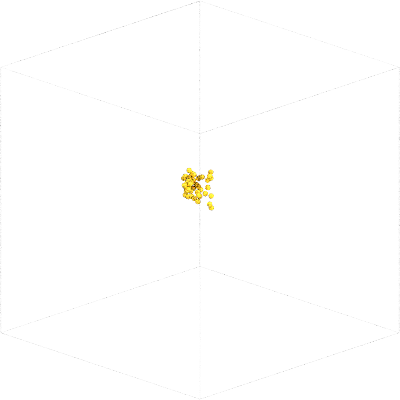

In [20]:
render(f[-1])

## Visualize trajectory

You could download the "trajectory.gsd" and visualize it in OVITO software.

In [21]:
from google.colab import files
files.download('trajectory.gsd')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>